# Setup

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

In [3]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8476217e-eb24-47a1-be75-90bef2003fc9;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 378ms :: artifacts dl 22ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.4.0


## Load in Comments Dataframes

In [4]:
# Tegveer's S3 -- DO NOT CHANGE
s3_directory_comms = f"s3a://sagemaker-us-east-1-433974840707/project/ml_comments/"

# Read all the Parquet files in the directory into a DataFrame
df_comments = spark.read.parquet(s3_directory_comms)

23/12/07 02:13:59 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [5]:
print("Number of records in sampled and filtered df: ", df_comments.count())

Number of records in sampled and filtered df:  13242001


In [6]:
df_comments.groupby('controversiality').count().show()

+----------------+--------+
|controversiality|   count|
+----------------+--------+
|               0|12311780|
|               1|  930221|
+----------------+--------+



In [7]:
df_comments.printSchema()

root
 |-- controversiality: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- weight: double (nullable = true)



# Load in models + Evaluate performance

In [5]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from pyspark.ml.pipeline import PipelineModel
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# random forest
rf_path = "s3a://sagemaker-us-east-1-433974840707/project/ml/rf/rf.model"
rf = PipelineModel.load(rf_path)

# log reg
lr_path = "s3a://sagemaker-us-east-1-433974840707/project/ml/lr/lr.model"
lr = PipelineModel.load(lr_path)

# gradient boosted tree
gbt_path = "s3a://sagemaker-us-east-1-433974840707/project/ml/gbt/gbt.model"
gbt = PipelineModel.load(gbt_path)

# svm
svm_path = "s3a://sagemaker-us-east-1-433974840707/project/ml/svm/svm.model"
svm = PipelineModel.load(svm_path)

## Split data into train, test, and validation

In [7]:
train_data, test_data = df_comments.randomSplit([0.75, 0.25], 24)
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
#print("Number of validation records : " + str(val_data.count()))
train_data.cache()

Number of training records: 9931987


Number of testing records : 3310014


DataFrame[controversiality: string, distinguished: string, subreddit: string, year: int, month: int, day: int, gilded: int, score: int, weight: double]

# Random Forests

## Fit Pipeline and Train Model

In [11]:
predictions_train = rf.transform(train_data)
predictions_train.show(5)

+----------------+-------------+------------+----+-----+---+------+-----+------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+--------------------+----------+-------------------------+
|controversiality|distinguished|   subreddit|year|month|day|gilded|score|            weight|controversiality_str|distinguished_ix|subreddit_ix|subreddit_vec|            features|       rawPrediction|         probability|prediction|predictedControversiality|
+----------------+-------------+------------+----+-----+---+------+-----+------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+--------------------+----------+-------------------------+
|               0|           no|Ask_Politics|2021|    1|  1|     0|   -9|0.5377776812126273|                 0.0|             0.0|         8.0|    (8,[],[])|[0.0,2021.0,1.0,1...|[5.96373789345213...|[0.19879126311507...|      

## Model Train Results

In [12]:
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality_str", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_train)

In [13]:
print("Train Accuracy = %g" % accuracy)
print("Train Error = %g" % (1.0 - accuracy))

Train Accuracy = 0.841495
Train Error = 0.158505


In [14]:
y_pred_train=predictions_train.select("prediction").collect()
y_orig_train=predictions_train.select("controversiality_str").collect()

In [15]:
cm = confusion_matrix(y_orig_train, y_pred_train)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[8010817 1223481]
 [ 350792  346897]]


## Model Test Results

In [8]:
predictions_test = rf.transform(test_data)

In [17]:
# Evaluate the model using ROC AUC
rf_fpr, rf_tpr, thresholds = roc_curve(predictions_test.select("controversiality_str").collect(), predictions_test.select("probability").rdd.map(lambda x: x[0][1]).collect())
rf_roc_auc = auc(rf_fpr, rf_tpr)

In [18]:
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality_str", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_test)
f1_score = evaluator.evaluate(predictions_test)
precision = evaluator.evaluate(predictions_test)
recall = evaluator.evaluate(predictions_test)

In [19]:
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))
print(f"F1-score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Test Accuracy = 0.841073
Test Error = 0.158927


In [9]:
y_pred_test=predictions_test.select("prediction").collect()
y_orig_test=predictions_test.select("controversiality_str").collect()

In [10]:
cm = confusion_matrix(y_orig_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2668634  408848]
 [ 117204  115328]]


In [22]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="controversiality_str", rawPredictionCol="prediction", metricName="areaUnderROC")
au_roc_test = binary_evaluator.evaluate(predictions_test)

In [23]:
print("Test Area Under ROC = %g" % au_roc_test)

Test Area Under ROC = 0.681557


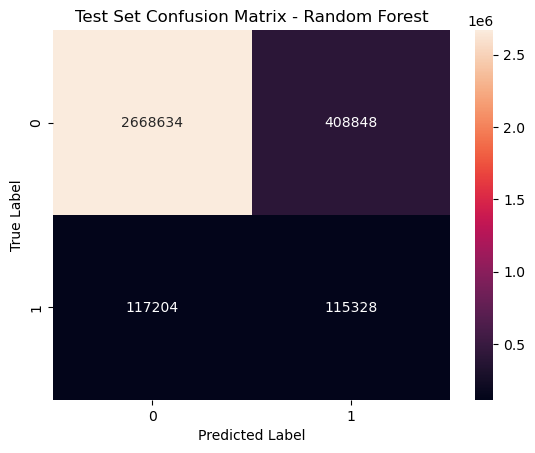

In [11]:
sns.heatmap(cm, annot=True, fmt='d')
# Save plot
plt.title("Test Set Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")  
plt.savefig('../../data/plots/test_conf_mtx_rf.png',bbox_inches='tight')
plt.savefig('../../website-source/test_conf_mtx_rf.png',bbox_inches='tight')
plt.show()

# Logistic Regression

## Model Train Results

In [25]:
predictions_train = lr.transform(train_data)
predictions_train.show(5)

+----------------+-------------+------------+----+-----+---+------+-----+------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+--------------------+----------+-------------------------+
|controversiality|distinguished|   subreddit|year|month|day|gilded|score|            weight|controversiality_str|distinguished_ix|subreddit_ix|subreddit_vec|            features|       rawPrediction|         probability|prediction|predictedControversiality|
+----------------+-------------+------------+----+-----+---+------+-----+------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+--------------------+----------+-------------------------+
|               0|           no|Ask_Politics|2021|    1|  1|     0|   -9|0.5377776812126273|                 0.0|             0.0|         8.0|    (8,[],[])|[0.0,2021.0,1.0,1...|[-1.0670038598624...|[0.25597328462265...|      

23/11/29 21:49:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [26]:
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality_str", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_train)

In [27]:
print("Train Accuracy = %g" % accuracy)
print("Train Error = %g" % (1.0 - accuracy))

Train Accuracy = 0.43819
Train Error = 0.56181


In [28]:
y_pred_train=predictions_train.select("prediction").collect()
y_orig_train=predictions_train.select("controversiality_str").collect()

In [29]:
cm = confusion_matrix(y_orig_train, y_pred_train)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3817686 5416612]
 [ 163278  534411]]


## Model Test Results

In [12]:
predictions_test = lr.transform(test_data)

In [31]:
# Evaluate the model using ROC AUC
l_fpr, l_tpr, l_thresholds = roc_curve(predictions_test.select("controversiality_str").collect(), predictions_test.select("probability").rdd.map(lambda x: x[0][1]).collect())
l_roc_auc = auc(l_fpr, l_tpr)

In [32]:
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality_str", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_test)
f1_score = evaluator.evaluate(predictions_test)
precision = evaluator.evaluate(predictions_test)
recall = evaluator.evaluate(predictions_test)

In [33]:
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))
print(f"F1-score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Test Accuracy = 0.438004
Test Error = 0.561996


In [13]:
y_pred_test=predictions_test.select("prediction").collect()
y_orig_test=predictions_test.select("controversiality_str").collect()

23/12/07 02:18:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [14]:
cm = confusion_matrix(y_orig_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1271788 1805694]
 [  54519  178013]]


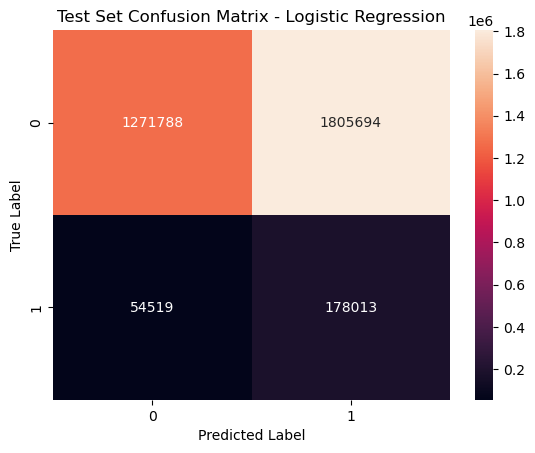

In [18]:
sns.heatmap(cm, annot=True, fmt='d')
# Save plot
plt.title("Test Set Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label") 
plt.savefig('../../data/plots/test_conf_mtx_lr.png',bbox_inches='tight')
plt.savefig('../../website-source/test_conf_mtx_lr.png',bbox_inches='tight')
plt.show()

# Gradient Boosted Trees

## Model Train Results

In [37]:
predictions_train = gbt.transform(train_data)
predictions_train.show(5)

+----------------+-------------+------------+----+-----+---+------+-----+------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+--------------------+----------+-------------------------+
|controversiality|distinguished|   subreddit|year|month|day|gilded|score|            weight|controversiality_str|distinguished_ix|subreddit_ix|subreddit_vec|            features|       rawPrediction|         probability|prediction|predictedControversiality|
+----------------+-------------+------------+----+-----+---+------+-----+------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+--------------------+----------+-------------------------+
|               0|           no|Ask_Politics|2021|    1|  1|     0|   -9|0.5377776812126273|                 0.0|             0.0|         8.0|    (8,[],[])|[0.0,2021.0,1.0,1...|[-0.4716534436838...|[0.28023285097629...|      

In [38]:
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality_str", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_train)

In [39]:
print("Train Accuracy = %g" % accuracy)
print("Train Error = %g" % (1.0 - accuracy))

Train Accuracy = 0.745802
Train Error = 0.254198


In [40]:
y_pred_train=predictions_train.select("prediction").collect()
y_orig_train=predictions_train.select("controversiality_str").collect()

In [41]:
cm = confusion_matrix(y_orig_train, y_pred_train)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6971788 2262510]
 [ 262180  435509]]


## Model Test Results

In [19]:
predictions_test = gbt.transform(test_data)

In [43]:
# Evaluate the model using ROC AUC
gbt_fpr, gbt_tpr, gbt_thresholds = roc_curve(predictions_test.select("controversiality_str").collect(), predictions_test.select("probability").rdd.map(lambda x: x[0][1]).collect())
gbt_roc_auc = auc(gbt_fpr, gbt_tpr)

In [44]:
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality_str", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_test)
f1_score = evaluator.evaluate(predictions_test)
precision = evaluator.evaluate(predictions_test)
recall = evaluator.evaluate(predictions_test)

In [45]:
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))
print(f"F1-score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Test Accuracy = 0.745551
Test Error = 0.254449


In [20]:
y_pred_test=predictions_test.select("prediction").collect()
y_orig_test=predictions_test.select("controversiality_str").collect()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [21]:
cm = confusion_matrix(y_orig_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2322902  754580]
 [  87650  144882]]


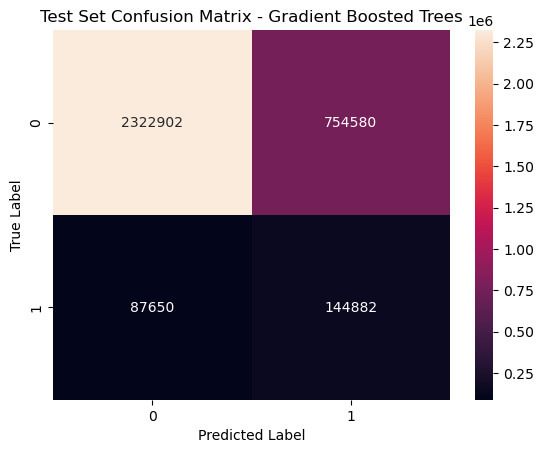

In [22]:
sns.heatmap(cm, annot=True, fmt='d')
# Save plot
plt.title("Test Set Confusion Matrix - Gradient Boosted Trees")
plt.xlabel("Predicted Label")
plt.ylabel("True Label") 
plt.savefig('../../data/plots/test_conf_mtx_gbt.png',bbox_inches='tight')
plt.savefig('../../website-source/test_conf_mtx_gbt.png',bbox_inches='tight')
plt.show()

# Support Vector Machines

## Model Train Results

In [49]:
predictions_train = svm.transform(train_data)
predictions_train.show(5)

+----------------+-------------+------------+----+-----+---+------+-----+------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+----------+-------------------------+
|controversiality|distinguished|   subreddit|year|month|day|gilded|score|            weight|controversiality_str|distinguished_ix|subreddit_ix|subreddit_vec|            features|       rawPrediction|prediction|predictedControversiality|
+----------------+-------------+------------+----+-----+---+------+-----+------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+----------+-------------------------+
|               0|           no|Ask_Politics|2021|    1|  1|     0|   -9|0.5377776812126273|                 0.0|             0.0|         8.0|    (8,[],[])|[0.0,2021.0,1.0,1...|[-1.8473000333116...|       1.0|                        1|
|               0|           no|Ask_Politics|2021|  

In [50]:
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality_str", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_train)

In [51]:
print("Train Accuracy = %g" % accuracy)
print("Train Error = %g" % (1.0 - accuracy))

Train Accuracy = 0.319869
Train Error = 0.680131


In [52]:
y_pred_train=predictions_train.select("prediction").collect()
y_orig_train=predictions_train.select("controversiality_str").collect()

In [ ]:
cm = confusion_matrix(y_orig_train, y_pred_train)
print("Confusion Matrix:")
print(cm)

## Model Test Results

In [ ]:
predictions_test = svm.transform(test_data)

In [ ]:
# Evaluate the model using ROC AUC
svm_fpr, svm_tpr, svm_thresholds = roc_curve(predictions_test.select("controversiality_str").collect(), predictions_test.select("probability").rdd.map(lambda x: x[0][1]).collect())
svm_roc_auc = auc(svm_fpr, svm_tpr)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality_str", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_test)
f1_score = evaluator.evaluate(predictions_test)
precision = evaluator.evaluate(predictions_test)
recall = evaluator.evaluate(predictions_test)

In [ ]:
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))
print(f"F1-score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

In [ ]:
y_pred_test=predictions_test.select("prediction").collect()
y_orig_test=predictions_test.select("controversiality_str").collect()

In [ ]:
cm = confusion_matrix(y_orig_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')
# Save plot
plt.title("Test Set Confusion Matrix - Support Vector Machines")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")  
plt.savefig('../../data/plots/test_conf_mtx_svm.png',bbox_inches='tight')
plt.savefig('../../website-source/test_conf_mtx_svm.png',bbox_inches='tight')
plt.show()

# Test Set AUC-ROC Curve Plot

In [ ]:
# Create a plot of the ROC curve
plt.figure(figsize=(8,6))
lw = 2
plt.plot(rf_fpr, rf_tpr, color='darkgreen', lw=lw, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(l_fpr, l_tpr, color='darkorange', lw=lw, label='Logistic Regression (area = %0.2f)' % l_roc_auc)
plt.plot(gbt_fpr, gbt_tpr, color='darkred', lw=lw, label='Gradient Boosted Trees (area = %0.2f)' % gbt_roc_auc)
plt.plot(svm_fpr, svm_tpr, color='darkblue', lw=lw, label='Support Vector Machines (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='darkgoldenrod', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set Receiver Operating Curve - Classifier Models')
plt.legend(loc="lower right")

# Save plot
plt.savefig('../../data/plots/AUC-ROC-controv.png',bbox_inches='tight')
plt.savefig('../../website-source/AUC-ROC-controv.png',bbox_inches='tight')

plt.show()